# -----------------------------------------------------------------------------
# Setup Initial Python Code for Reproducibility
# -----------------------------------------------------------------------------

In [ ]:
import tensorflow as tf
import numpy as np
import random
import os

# Set a fixed seed value for reproducibility
SEED = 1
random.seed(SEED)            # Python random module
np.random.seed(SEED)         # NumPy
tf.random.set_seed(SEED)     # TensorFlow

# Enforce deterministic behavior for GPU operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Ensure deterministic execution
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Deterministic cuDNN algorithms

# Control GPU memory allocation (prevents TensorFlow from using all GPU memory)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)  # Enable memory growth

# Restrict parallelism (ensures consistent execution order)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

import os
import scipy.io 
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd
from sklearn.metrics import f1_score, classification_report
from keras.callbacks import EarlyStopping

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import numpy as np

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    log_loss,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt


# -----------------------------------------------------------------------------
# Read CWRU Bearing Data (Load - 2HP)
# -----------------------------------------------------------------------------

In [2]:
folder_path = "/Users/user/Desktop/MEng_UWaterloo/7_ECE_699A_PRJ/Finalized Notebooks/CWRU_Data/2HP"

def load_cwru_data(folder_path = folder_path):
    """
    Load CWRU bearing data from .mat files into a DataFrame.

    Args:
        folder_path (str): Path to the dataset folder.

    Returns:
        pd.DataFrame: DataFrame with columns for condition, fault size, label, and signal.
    """
    data_dict = {
        'Condition': [],
        'Fault Size (mm)': [],
        'Fault Label': [],
        'Signal': []
    }

    # Define file mappings: (file_id, condition, fault_size, fault_label)
    file_mappings = [
        ('99', 'Normal', 0, 0),
        ('124', 'RE (Rolling element)', 0.18, 1),
        ('111', 'IR (Inner ring)', 0.18, 2),
        ('137', 'OR (Outer ring)', 0.18, 3),
        ('191', 'RE (Rolling element)', 0.36, 4),
        ('176', 'IR (Inner ring)', 0.36, 5),
        ('203', 'OR (Outer ring)', 0.36, 6),
        ('228', 'RE (Rolling element)', 0.54, 7),
        ('215', 'IR (Inner ring)', 0.54, 8),
        ('240', 'OR (Outer ring)', 0.54, 9)
    ]

    for file_id, condition, fault_size, fault_label in file_mappings:
        file_path = os.path.join(folder_path, f'{file_id}.mat')
        if file_id == '99':
            signal = scipy.io.loadmat(file_path)[f'X0{file_id}_DE_time'].flatten()
        else:
            signal = scipy.io.loadmat(file_path)[f'X{file_id}_DE_time'].flatten()
        data_dict['Condition'].append(condition)
        data_dict['Fault Size (mm)'].append(fault_size)
        data_dict['Fault Label'].append(fault_label)
        data_dict['Signal'].append(signal)

    return pd.DataFrame(data_dict)

In [3]:
## Load data into a dataframe
df = load_cwru_data(folder_path=folder_path)
df.head()

,Condition,Fault Size (mm),Fault Label,Signal
0,Normal,0.00,0,"[0.06425353846153846, 0.06300184615384616, -0...."
1,RE (Rolling element),0.18,1,"[0.09992676923076924, 0.14164984615384615, 0.1..."
2,IR (Inner ring),0.18,2,"[0.06133292307692308, -0.015646153846153844, -..."
3,OR (Outer ring),0.18,3,"[-0.967796, -1.7336026666666666, -2.226056, -2..."
4,RE (Rolling element),0.36,4,"[0.06446215384615385, 0.09575446153846154, 0.1..."


# -----------------------------------------------------------------------------
# Data Processing and Feature Extraction with Imbalanced Data
# -----------------------------------------------------------------------------

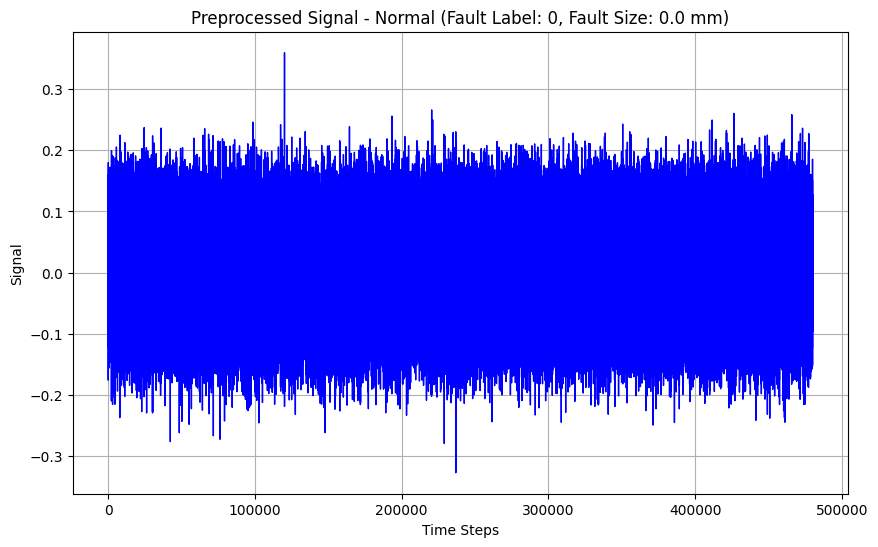

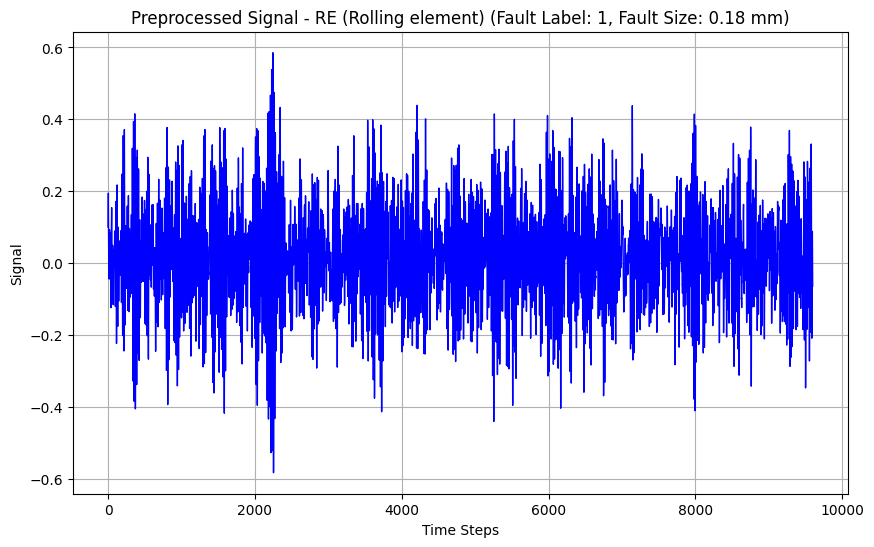

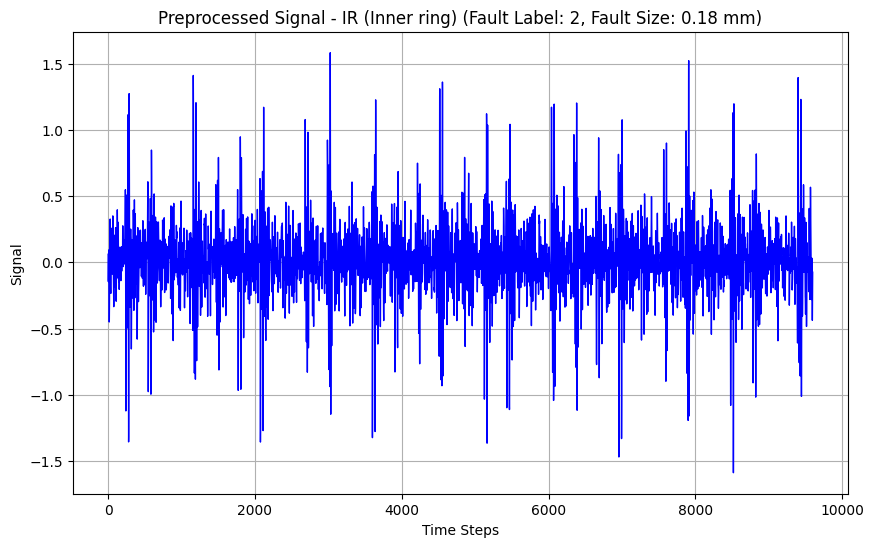

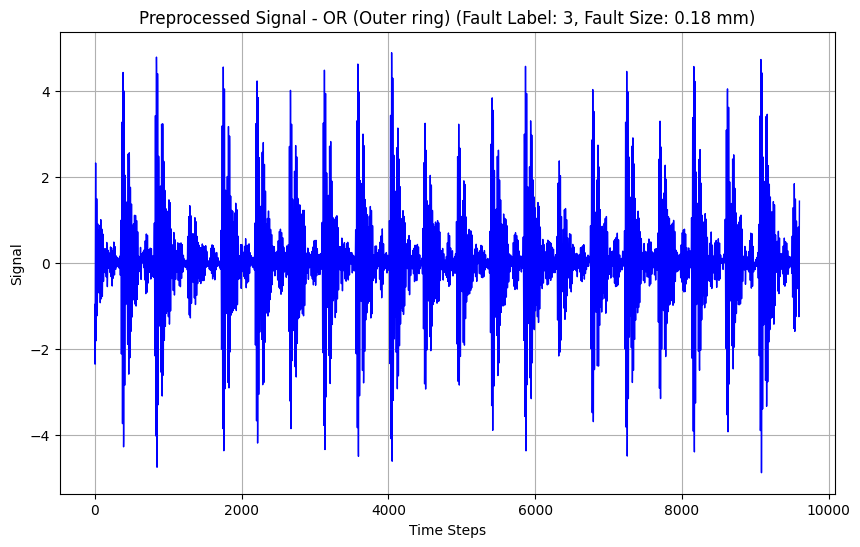

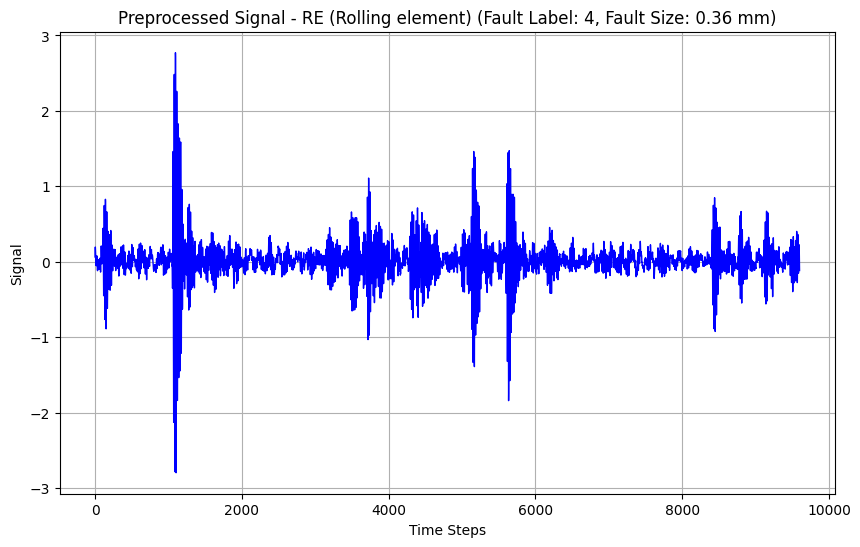

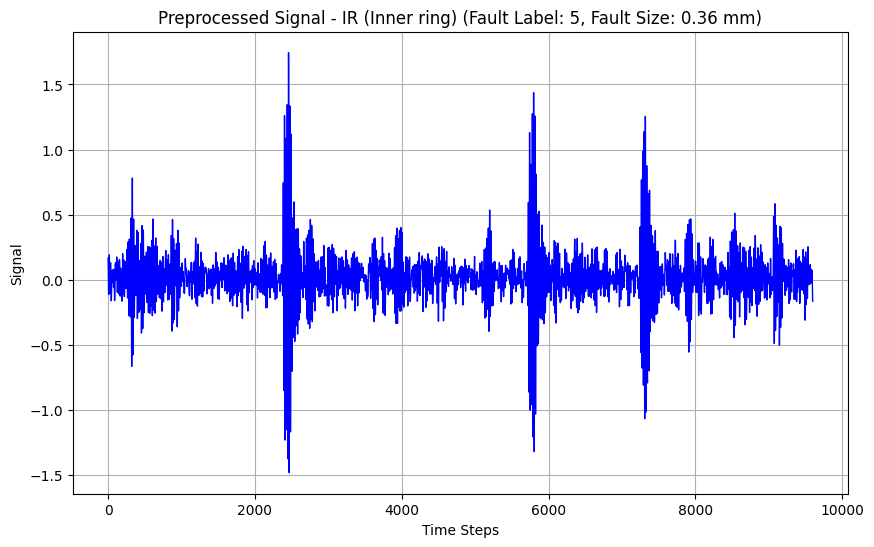

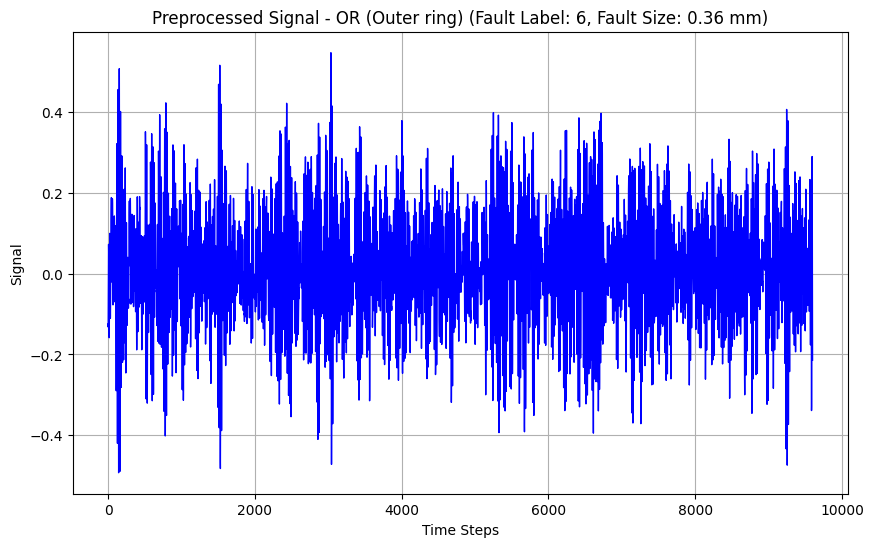

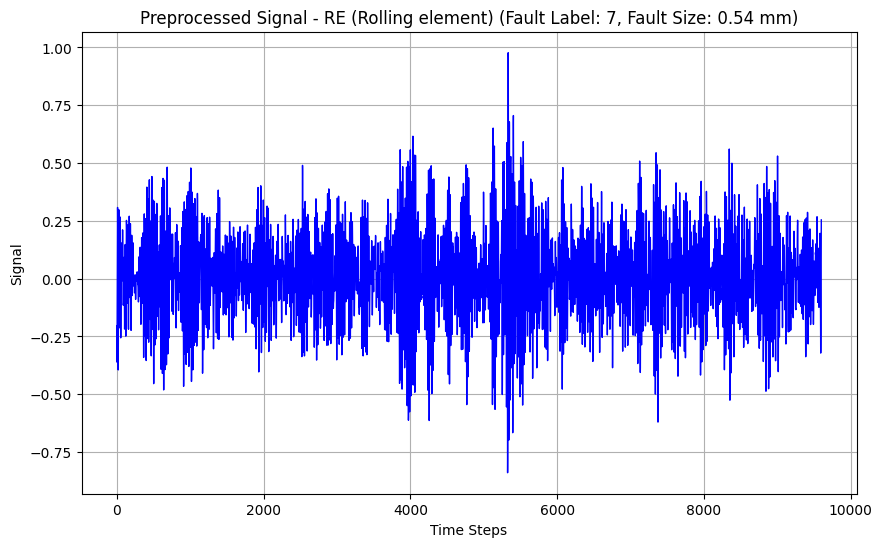

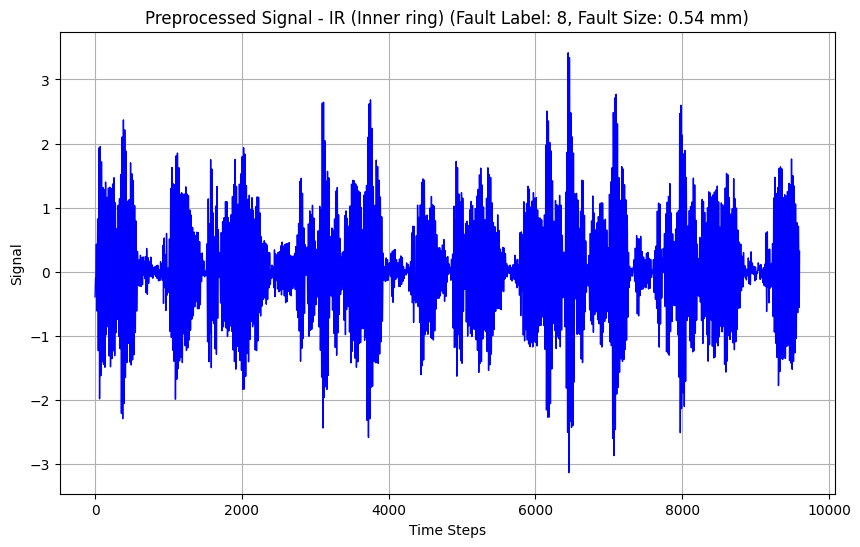

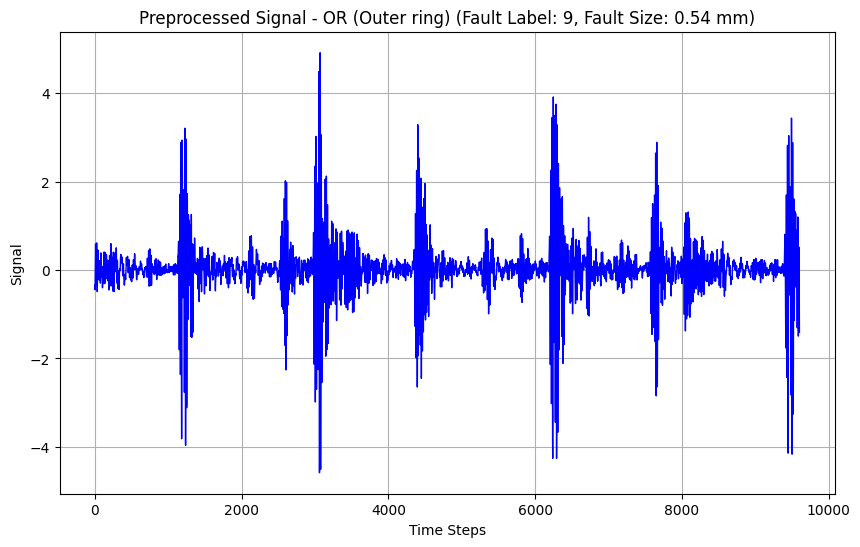

In [4]:
# Function to preprocess data for imbalance with different points for each label
def preprocess_data_for_imbalance(df, start_point_dict, num_points_dict):
    """
    Preprocess data by selecting a section of the signal for each fault label
    based on a given start point and number of points for each label.

    Args:
        df (pd.DataFrame): Input DataFrame containing signals and labels.
        start_point_dict (dict): Dictionary specifying the start point for each label.
        num_points_dict (dict): Dictionary specifying the number of points for each label.

    Returns:
        pd.DataFrame: Processed DataFrame with signals for each label.
    """
    processed_data = {
        'Condition': [],
        'Fault Size (mm)': [],
        'Fault Label': [],
        'Signal': []
    }

    for fault_label in df['Fault Label'].unique():
        subset = df[df['Fault Label'] == fault_label]
        if subset.empty:
            continue

        signal = subset.iloc[0]['Signal']
        condition = subset.iloc[0]['Condition']
        fault_size = subset.iloc[0]['Fault Size (mm)']

        # Get start point and number of points for the current label
        start_point = start_point_dict.get(fault_label, 0)  # Default start_point is 0
        num_points = num_points_dict.get(fault_label, len(signal))  # Default is full signal length

        # Validate range
        if start_point >= len(signal):
            print(f"Start point {start_point} is out of range for signal with length {len(signal)}. Skipping Fault Label {fault_label}.")
            continue

        end_point = min(start_point + num_points, len(signal))
        signal_section = signal[start_point:end_point]

        # Append to processed data
        processed_data['Condition'].append(condition)
        processed_data['Fault Size (mm)'].append(fault_size)
        processed_data['Fault Label'].append(fault_label)
        processed_data['Signal'].append(signal_section)

    return pd.DataFrame(processed_data)

# Function to plot signals after preprocessing
def plot_preprocessed_signals(df_imbalance):
    """
    Plot the preprocessed signals for each fault label.

    Args:
        df_imbalance (pd.DataFrame): Processed DataFrame containing signals and labels.
    """
    for fault_label in df_imbalance['Fault Label'].unique():
        subset = df_imbalance[df_imbalance['Fault Label'] == fault_label]
        if subset.empty:
            continue

        signal = subset.iloc[0]['Signal']
        condition = subset.iloc[0]['Condition']
        fault_size = subset.iloc[0]['Fault Size (mm)']

        plt.figure(figsize=(10, 6))
        plt.plot(signal, color='blue', linewidth=1)
        plt.title(f"Preprocessed Signal - {condition} (Fault Label: {fault_label}, Fault Size: {fault_size} mm)")
        plt.xlabel("Time Steps")
        plt.ylabel("Signal")
        plt.grid(True)
        plt.show()


# All classes start at index 0
start_point_dict_train = {label: 0 for label in range(10)}

# Imbalanced case: IR ratio = 50:1 for normal (class 0) vs. faults (classes 1–9)
num_points_dict_train = {0: 480000, **{label: 9600 for label in range(1, 10)}}


# Preprocess data and save to df_imbalance
df_imbalance_train = preprocess_data_for_imbalance(df, start_point_dict_train, num_points_dict_train)

# # Plot preprocessed signals
plot_preprocessed_signals(df_imbalance_train)


# -----------------------------------------------------------------------------
# Windowing and Overlapping Helper Functions
# -----------------------------------------------------------------------------

In [5]:
# Sampling function
def sampling(data, interval_length, samples_per_block, ignore_points=0):
    """
    Split signal data into blocks with specified intervals and block size.
    
    Args:
        data (np.array): Input signal data.
        interval_length (int): Step size for sampling.
        samples_per_block (int): Number of samples per block.
        ignore_points (int): Number of points to ignore at the start and end.
    
    Returns:
        np.array: Split data blocks.
    """
    adjusted_length = len(data) - 2 * ignore_points
    num_blocks = (
        round(adjusted_length / interval_length) - round(samples_per_block / interval_length) - 1
    )
    split_data = np.zeros([num_blocks, samples_per_block])

    for i in range(num_blocks):
        start_idx = ignore_points + i * interval_length
        split_data[i, :] = data[start_idx:(start_idx + samples_per_block)].T

    return split_data


def data_preparation(data, interval_length, samples_per_block):
    """
    Prepare data by splitting and labeling for multi-class classification.
    
    Args:
        data (list): List of signal data for all classes.
        interval_length (int): Step size for sampling.
        samples_per_block (int): Number of samples per block.
    
    Returns:
        tuple: Prepared data (X), positional labels (y_positional), and class labels (y_class).
    """
    for count, signal in enumerate(data):
        split_data = sampling(signal, interval_length, samples_per_block)
        y = np.zeros([len(split_data), 10])  # One-hot encoding
        y[:, count] = 1
        y_class = np.zeros([len(split_data), 1])
        y_class[:, 0] = count

        if count == 0:
            X = split_data
            y_positional = y
            y_label = y_class
        else:
            X = np.append(X, split_data, axis=0)
            y_positional = np.append(y_positional, y, axis=0)
            y_label = np.append(y_label, y_class, axis=0)

    return X, y_positional, y_label


def prepare_datasets(df_imbalance, interval_length, samples_per_block):
    """
    Prepare train or test datasets using the data_preparation function.
    
    Args:
        df_imbalance (pd.DataFrame): DataFrame containing signals and labels.
        interval_length (int): Interval length for sampling.
        samples_per_block (int): Number of samples per block.
    
    Returns:
        tuple: X (input data), y_positional (one-hot labels), y_class (class labels).
    """
    signals = df_imbalance['Signal'].tolist()
    X, y_positional, y_class = data_preparation(signals, interval_length, samples_per_block)
    return X, y_positional, y_class


# Set parameters
interval_length = 320
samples_per_block = 1600


# Prepare train datasets
X, y_positional, y_class = prepare_datasets(df_imbalance_train, interval_length, samples_per_block)



In [6]:
X.shape

(1710, 1600)

# -----------------------------------------------------------------------------
# Multiclass Classification CNN Model Training with Imbalanced Data
# -----------------------------------------------------------------------------

In [7]:
# Split into training and test sets (80% train, 20% test)

# X_train_split, X_test_split, y_train_positional_split, y_test_positional_split, y_train_split, y_test_split = train_test_split(
#     X_train, y_train_positional, y_train, test_size=0.2, random_state=42, stratify=y_train_positional)


def time_series_stratified_split(X, y, train_ratio = 0.8):
    num_classes = y.shape[1]
    X_train, y_train, X_test, y_test = [], [], [], []

    for cls in range(num_classes):
        cls_indices = np.where(np.argmax(y, axis=1) == cls)[0]
        n_train = int(train_ratio * len(cls_indices))
        train_idx, test_idx = cls_indices[:n_train], cls_indices[n_train:]
        X_train.append(X[train_idx])
        # print("X_train shape:", len(X_train))
        y_train.append(y[train_idx])
        # print("y_train shape:", len(X_train))
        X_test.append(X[test_idx])
        # print("X_train shape:", len(X_train))
        y_test.append(y[test_idx])
        # print("y_test shape:", len(X_train))

    return (
        np.concatenate(X_train),
        np.concatenate(y_train),
        np.concatenate(X_test),
        np.concatenate(y_test)
    )


# -----------------------------------------------------------------------------
# Define CNN Model
# -----------------------------------------------------------------------------

In [8]:
class CNN_1D():
    def __init__(self):
        self.model = self.CreateModel()
        self.model.summary()

    def CreateModel(self):
        model = models.Sequential([
            layers.Conv1D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=input_shape),
            layers.BatchNormalization(),
            layers.MaxPool1D(pool_size=2),
            
            layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool1D(pool_size=2),

            layers.Conv1D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
            layers.BatchNormalization(),
            layers.MaxPool1D(pool_size=2),

            layers.GlobalAveragePooling1D(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.3),
            layers.Dense(10, activation='softmax')
        ])

        # Optimizer with a slightly higher learning rate
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])
        return model

1. Stratifying on one-hot labels (y_train_positional) is incorrect in principle. It should be stratify=np.argmax(y_train_positional, axis=1) or just stratify=y_train if it's 1D. This may not error, but can silently behave incorrectly or inconsistently.


2. In K-Fold cross-validation, the training data is split into multiple subsets (folds), and in each iteration, the model is trained on a specific training subset and validated on a corresponding validation subset. A common mistake is to evaluate the model on the entire training dataset instead of just the training portion of the current fold. This inflates the reported performance metrics, as the model sees data it wasn't trained on during that fold. To ensure accurate fold-wise evaluation, metrics should be computed using only the training indices (train_idx) associated with the current fold. This maintains the integrity of the cross-validation process and provides realistic performance estimates.


Fold 1


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 12,874 (50.29 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/50


2025-06-23 23:55:20.328312: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-23 23:55:20.329542: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6459 - loss: 1.3878
Epoch 1: val_accuracy improved from -inf to 0.01460, saving model to CNN1D_results/IR_50_1_Ratio/best_model_1.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.6598 - loss: 1.3442 - val_accuracy: 0.0146 - val_loss: 2.2811
Epoch 2/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9046 - loss: 0.2976
Epoch 2: val_accuracy did not improve from 0.01460
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9050 - loss: 0.2962 - val_accuracy: 0.0146 - val_loss: 2.6573
Epoch 3/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9202 - loss: 0.2247
Epoch 3: val_accuracy did not improve from 0.01460
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9205 - loss: 0.2241 - val_accuracy: 0.0146 - val_loss: 3.0222
Epoch 4/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9351 - loss: 0.1977
Epoch 4: val_accuracy did not improve from 0.01460
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9352 - loss: 0.1974 - val_accuracy: 0.0146 - val_loss: 3.4325
Epoch 5/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9397 - loss: 0.1729
Epoch 5: val_accuracy did not improve from 

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9595 - loss: 0.1310 - val_accuracy: 0.0182 - val_loss: 6.0877
Epoch 9/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9614 - loss: 0.1146
Epoch 9: val_accuracy did not improve from 0.01825
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9613 - loss: 0.1149 - val_accuracy: 0.0182 - val_loss: 7.1004
Epoch 10/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9602 - loss: 0.1076
Epoch 10: val_accuracy improved from 0.01825 to 0.02555, saving model to CNN1D_results/IR_50_1_Ratio/best_model_1.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9604 - loss: 0.1076 - val_accuracy: 0.0255 - val_loss: 7.6463
Epoch 11/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9741 - loss: 0.0868
Epoch 11: val_accuracy did not improve from 0.02555
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9738 - loss: 0.0873 - val_accuracy: 0.0219 - val_loss: 8.3645
Epoch 12/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9663 - loss: 0.0883
Epoch 12: val_accuracy did not improve from 0.02555
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9667 - loss: 0.0882 - val_accuracy: 0.0182 - val_loss: 8.5889
Epoch 13/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9717 - loss: 0.0800
Epoch 13: val_accuracy did not improve from 0.02555
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9716 - loss: 0.0799 - val_accuracy: 0.0255 - val_loss: 8.0388
Epoch 14/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9655 - loss: 0.0783
Epoch 14: val_accuracy improved from

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9656 - loss: 0.0784 - val_accuracy: 0.0328 - val_loss: 6.8533
Epoch 15/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9711 - loss: 0.0811
Epoch 15: val_accuracy did not improve from 0.03285
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9707 - loss: 0.0811 - val_accuracy: 0.0328 - val_loss: 5.4976
Epoch 16/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9705 - loss: 0.0784
Epoch 16: val_accuracy improved from 0.03285 to 0.05474, saving model to CNN1D_results/IR_50_1_Ratio/best_model_1.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9710 - loss: 0.0777 - val_accuracy: 0.0547 - val_loss: 4.4237
Epoch 17/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9797 - loss: 0.0641
Epoch 17: val_accuracy did not improve from 0.05474
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9796 - loss: 0.0646 - val_accuracy: 0.0511 - val_loss: 1.9335
Epoch 18/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9765 - loss: 0.0651
Epoch 18: val_accuracy improved from 0.05474 to 0.92701, saving model to CNN1D_results/IR_50_1_Ratio/best_model_1.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9764 - loss: 0.0648 - val_accuracy: 0.9270 - val_loss: 0.4527
Epoch 19/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9836 - loss: 0.0550
Epoch 19: val_accuracy improved from 0.92701 to 0.95620, saving model to CNN1D_results/IR_50_1_Ratio/best_model_1.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9831 - loss: 0.0557 - val_accuracy: 0.9562 - val_loss: 0.1155
Epoch 20/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9748 - loss: 0.0627
Epoch 20: val_accuracy did not improve from 0.95620
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9748 - loss: 0.0627 - val_accuracy: 0.9562 - val_loss: 0.0823
Epoch 21/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9758 - loss: 0.0547
Epoch 21: val_accuracy improved from 0.95620 to 0.97080, saving model to CNN1D_results/IR_50_1_Ratio/best_model_1.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9759 - loss: 0.0547 - val_accuracy: 0.9708 - val_loss: 0.0655
Epoch 22/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9875 - loss: 0.0461
Epoch 22: val_accuracy did not improve from 0.97080
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9875 - loss: 0.0461 - val_accuracy: 0.9599 - val_loss: 0.0829
Epoch 23/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9899 - loss: 0.0467
Epoch 23: val_accuracy improved from 0.97080 to 0.98540, saving model to CNN1D_results/IR_50_1_Ratio/best_model_1.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9897 - loss: 0.0468 - val_accuracy: 0.9854 - val_loss: 0.0446
Epoch 24/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9872 - loss: 0.0486
Epoch 24: val_accuracy did not improve from 0.98540
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9871 - loss: 0.0484 - val_accuracy: 0.9562 - val_loss: 0.1342
Epoch 25/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9879 - loss: 0.0479
Epoch 25: val_accuracy did not improve from 0.98540
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9878 - loss: 0.0475 - val_accuracy: 0.9854 - val_loss: 0.0397
Epoch 26/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9891 - loss: 0.0359
Epoch 26: val_accuracy did not improve from 0.98540
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9889 - loss: 0.0362 - val_accuracy: 0.9854 - val_loss: 0.0467
Epoch 27/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9821 - loss: 0.0413
Epoch 27: val_accuracy did not impro

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9891 - loss: 0.0297 - val_accuracy: 0.9927 - val_loss: 0.0334
Epoch 37/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9940 - loss: 0.0228
Epoch 37: val_accuracy did not improve from 0.99270
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9940 - loss: 0.0228 - val_accuracy: 0.9745 - val_loss: 0.0613
Epoch 38/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9910 - loss: 0.0229
Epoch 38: val_accuracy did not improve from 0.99270
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9910 - loss: 0.0230 - val_accuracy: 0.9854 - val_loss: 0.0277
Epoch 39/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9951 - loss: 0.0201
Epoch 39: val_accuracy did not improve from 0.99270
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9949 - loss: 0.0204 - val_accuracy: 0.9854 - val_loss: 0.0265
Epoch 40/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9967 - loss: 0.0181
Epoch 40: val_accuracy did not impro

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9919 - loss: 0.0230 - val_accuracy: 0.9964 - val_loss: 0.0201
Epoch 42/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9956 - loss: 0.0173
Epoch 42: val_accuracy did not improve from 0.99635
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9956 - loss: 0.0173 - val_accuracy: 0.9818 - val_loss: 0.0426
Epoch 43/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 0.9956 - loss: 0.0196
Epoch 43: val_accuracy did not improve from 0.99635
35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 868ms/step - accuracy: 0.9956 - loss: 0.0197 - val_accuracy: 0.9708 - val_loss: 0.0610
Epoch 44/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9977 - loss: 0.0130
Epoch 44: val_accuracy did not improve from 0.99635
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9976 - loss: 0.0132 - val_accuracy: 0.9781 - val_loss: 0.0442
Epoch 45/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9949 - loss: 0.0159
Epoch 45: val_accuracy did not im

 1/35 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step

2025-06-23 23:57:05.173221: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-23 23:57:05.174201: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Best model saved at: CNN1D_results/IR_50_1_Ratio/best_model_1.h5

Fold 2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 12,874 (50.29 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6519 - loss: 1.4293
Epoch 1: val_accuracy improved from -inf to 0.87546, saving model to CNN1D_results/IR_50_1_Ratio/best_model_2.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6662 - loss: 1.3818 - val_accuracy: 0.8755 - val_loss: 1.8968
Epoch 2/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8957 - loss: 0.2889
Epoch 2: val_accuracy did not improve from 0.87546
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8958 - loss: 0.2884 - val_accuracy: 0.1795 - val_loss: 2.1358
Epoch 3/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9070 - loss: 0.2653
Epoch 3: val_accuracy did not improve from 0.87546
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9068 - loss: 0.2649 - val_accuracy: 0.0147 - val_loss: 2.5136
Epoch 4/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9196 - loss: 0.2398
Epoch 4: val_accuracy did not improve from 0.87546
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9196 - loss: 0.2395 - val_accuracy: 0.0147 - val_loss: 2.9036
Epoch 5/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9173 - loss: 0.2216
Epoch 5: val_accuracy did not improve from 

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9733 - loss: 0.0724 - val_accuracy: 0.9377 - val_loss: 0.6955
Epoch 18/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9778 - loss: 0.0696
Epoch 18: val_accuracy improved from 0.93773 to 0.96703, saving model to CNN1D_results/IR_50_1_Ratio/best_model_2.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9774 - loss: 0.0699 - val_accuracy: 0.9670 - val_loss: 0.0974
Epoch 19/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9743 - loss: 0.0638
Epoch 19: val_accuracy improved from 0.96703 to 0.97436, saving model to CNN1D_results/IR_50_1_Ratio/best_model_2.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9745 - loss: 0.0638 - val_accuracy: 0.9744 - val_loss: 0.0915
Epoch 20/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9792 - loss: 0.0597
Epoch 20: val_accuracy did not improve from 0.97436
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9793 - loss: 0.0597 - val_accuracy: 0.9707 - val_loss: 0.0857
Epoch 21/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9839 - loss: 0.0633
Epoch 21: val_accuracy did not improve from 0.97436
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9837 - loss: 0.0635 - val_accuracy: 0.9707 - val_loss: 0.0664
Epoch 22/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9763 - loss: 0.0603
Epoch 22: val_accuracy did not improve from 0.97436
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9762 - loss: 0.0606 - val_accuracy: 0.9744 - val_loss: 0.0729
Epoch 23/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9853 - loss: 0.0458
Epoch 23: val_accuracy did not impro

35/35 ━━━━━━━━━━━━━━━━━━━━ 916s 27s/step - accuracy: 0.9887 - loss: 0.0425 - val_accuracy: 0.9817 - val_loss: 0.0542
Epoch 26/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9923 - loss: 0.0325
Epoch 26: val_accuracy did not improve from 0.98168
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9921 - loss: 0.0328 - val_accuracy: 0.9744 - val_loss: 0.0535
Epoch 27/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9886 - loss: 0.0394
Epoch 27: val_accuracy did not improve from 0.98168
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9885 - loss: 0.0398 - val_accuracy: 0.9670 - val_loss: 0.0597
Epoch 28/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9914 - loss: 0.0351
Epoch 28: val_accuracy did not improve from 0.98168
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9911 - loss: 0.0355 - val_accuracy: 0.9780 - val_loss: 0.0528
Epoch 29/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9885 - loss: 0.0396
Epoch 29: val_accuracy did not impr

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9964 - loss: 0.0179 - val_accuracy: 0.9853 - val_loss: 0.0325
Epoch 46/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9952 - loss: 0.0140
Epoch 46: val_accuracy did not improve from 0.98535
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9952 - loss: 0.0143 - val_accuracy: 0.9817 - val_loss: 0.0439
Epoch 47/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9927 - loss: 0.0194
Epoch 47: val_accuracy did not improve from 0.98535
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9928 - loss: 0.0194 - val_accuracy: 0.9707 - val_loss: 0.0431
Epoch 48/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9936 - loss: 0.0206
Epoch 48: val_accuracy did not improve from 0.98535
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9935 - loss: 0.0206 - val_accuracy: 0.9780 - val_loss: 0.0655
Epoch 49/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9949 - loss: 0.0174
Epoch 49: val_accuracy did not impro

 1/35 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step

2025-06-24 00:13:33.347822: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-24 00:13:33.348722: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best model saved at: CNN1D_results/IR_50_1_Ratio/best_model_2.h5

Fold 3


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 12,874 (50.29 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6058 - loss: 1.6425
Epoch 1: val_accuracy improved from -inf to 0.87546, saving model to CNN1D_results/IR_50_1_Ratio/best_model_3.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6217 - loss: 1.5945 - val_accuracy: 0.8755 - val_loss: 1.8510
Epoch 2/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8885 - loss: 0.3417
Epoch 2: val_accuracy did not improve from 0.87546
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8895 - loss: 0.3385 - val_accuracy: 0.8755 - val_loss: 1.8530
Epoch 3/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9082 - loss: 0.2534
Epoch 3: val_accuracy did not improve from 0.87546
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9086 - loss: 0.2527 - val_accuracy: 0.0147 - val_loss: 2.1733
Epoch 4/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9228 - loss: 0.2070
Epoch 4: val_accuracy did not improve from 0.87546
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9232 - loss: 0.2062 - val_accuracy: 0.0147 - val_loss: 2.4603
Epoch 5/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9291 - loss: 0.1945
Epoch 5: val_accuracy did not improve from 

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9813 - loss: 0.0674 - val_accuracy: 0.9194 - val_loss: 0.6992
Epoch 17/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9895 - loss: 0.0514
Epoch 17: val_accuracy improved from 0.91941 to 0.92674, saving model to CNN1D_results/IR_50_1_Ratio/best_model_3.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9891 - loss: 0.0518 - val_accuracy: 0.9267 - val_loss: 0.3440
Epoch 18/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9792 - loss: 0.0536
Epoch 18: val_accuracy improved from 0.92674 to 0.93773, saving model to CNN1D_results/IR_50_1_Ratio/best_model_3.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9792 - loss: 0.0538 - val_accuracy: 0.9377 - val_loss: 0.1843
Epoch 19/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9820 - loss: 0.0543
Epoch 19: val_accuracy improved from 0.93773 to 0.95604, saving model to CNN1D_results/IR_50_1_Ratio/best_model_3.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9822 - loss: 0.0543 - val_accuracy: 0.9560 - val_loss: 0.1054
Epoch 20/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9829 - loss: 0.0459
Epoch 20: val_accuracy did not improve from 0.95604
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9831 - loss: 0.0459 - val_accuracy: 0.9451 - val_loss: 0.1119
Epoch 21/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9852 - loss: 0.0477
Epoch 21: val_accuracy improved from 0.95604 to 0.97070, saving model to CNN1D_results/IR_50_1_Ratio/best_model_3.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9853 - loss: 0.0475 - val_accuracy: 0.9707 - val_loss: 0.0667
Epoch 22/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9908 - loss: 0.0363
Epoch 22: val_accuracy did not improve from 0.97070
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9906 - loss: 0.0368 - val_accuracy: 0.9707 - val_loss: 0.0598
Epoch 23/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9888 - loss: 0.0374
Epoch 23: val_accuracy did not improve from 0.97070
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9885 - loss: 0.0381 - val_accuracy: 0.9634 - val_loss: 0.0764
Epoch 24/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9851 - loss: 0.0430
Epoch 24: val_accuracy did not improve from 0.97070
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9850 - loss: 0.0429 - val_accuracy: 0.9634 - val_loss: 0.0845
Epoch 25/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9852 - loss: 0.0367
Epoch 25: val_accuracy did not impro

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9919 - loss: 0.0355 - val_accuracy: 0.9780 - val_loss: 0.0435
Epoch 28/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9854 - loss: 0.0329
Epoch 28: val_accuracy improved from 0.97802 to 0.98168, saving model to CNN1D_results/IR_50_1_Ratio/best_model_3.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9855 - loss: 0.0333 - val_accuracy: 0.9817 - val_loss: 0.0477
Epoch 29/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9960 - loss: 0.0275
Epoch 29: val_accuracy improved from 0.98168 to 0.98901, saving model to CNN1D_results/IR_50_1_Ratio/best_model_3.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9960 - loss: 0.0277 - val_accuracy: 0.9890 - val_loss: 0.0392
Epoch 30/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9892 - loss: 0.0332
Epoch 30: val_accuracy did not improve from 0.98901
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9891 - loss: 0.0334 - val_accuracy: 0.9780 - val_loss: 0.0357
Epoch 31/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9881 - loss: 0.0294
Epoch 31: val_accuracy did not improve from 0.98901
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9881 - loss: 0.0296 - val_accuracy: 0.9853 - val_loss: 0.0514
Epoch 32/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9889 - loss: 0.0311
Epoch 32: val_accuracy improved from 0.98901 to 1.00000, saving model to CNN1D_results/IR_50_1_Ratio/best_model_3.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9891 - loss: 0.0310 - val_accuracy: 1.0000 - val_loss: 0.0290
Epoch 33/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9889 - loss: 0.0244
Epoch 33: val_accuracy did not improve from 1.00000
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9889 - loss: 0.0245 - val_accuracy: 0.9963 - val_loss: 0.0342
Epoch 34/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9910 - loss: 0.0215
Epoch 34: val_accuracy did not improve from 1.00000
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9908 - loss: 0.0221 - val_accuracy: 0.9890 - val_loss: 0.0349
Epoch 35/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9881 - loss: 0.0344
Epoch 35: val_accuracy did not improve from 1.00000
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9880 - loss: 0.0347 - val_accuracy: 0.9634 - val_loss: 0.1332
Epoch 36/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9971 - loss: 0.0249
Epoch 36: val_accuracy did not impro

2025-06-24 00:25:58.714841: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-24 00:25:58.716032: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Best model saved at: CNN1D_results/IR_50_1_Ratio/best_model_3.h5

Fold 4


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 12,874 (50.29 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4326 - loss: 2.1317
Epoch 1: val_accuracy improved from -inf to 0.87546, saving model to CNN1D_results/IR_50_1_Ratio/best_model_4.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4553 - loss: 2.0861 - val_accuracy: 0.8755 - val_loss: 1.9491
Epoch 2/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8918 - loss: 0.4468
Epoch 2: val_accuracy improved from 0.87546 to 0.87912, saving model to CNN1D_results/IR_50_1_Ratio/best_model_4.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8921 - loss: 0.4402 - val_accuracy: 0.8791 - val_loss: 1.8332
Epoch 3/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9164 - loss: 0.2547
Epoch 3: val_accuracy did not improve from 0.87912
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9157 - loss: 0.2542 - val_accuracy: 0.0110 - val_loss: 2.4590
Epoch 4/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9119 - loss: 0.2308
Epoch 4: val_accuracy did not improve from 0.87912
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9123 - loss: 0.2299 - val_accuracy: 0.0110 - val_loss: 3.1110
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9259 - loss: 0.1963
Epoch 5: val_accuracy did not improve from 0.87912
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9259 - loss: 0.1960 - val_accuracy: 0.0110 - val_loss: 3.6746
Epoch 6/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9364 - loss: 0.1736
Epoch 6: val_accuracy did not improve from 

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9807 - loss: 0.0649 - val_accuracy: 0.9158 - val_loss: 0.4346
Epoch 19/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9758 - loss: 0.0610
Epoch 19: val_accuracy improved from 0.91575 to 0.94139, saving model to CNN1D_results/IR_50_1_Ratio/best_model_4.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9757 - loss: 0.0609 - val_accuracy: 0.9414 - val_loss: 0.1867
Epoch 20/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9756 - loss: 0.0573
Epoch 20: val_accuracy did not improve from 0.94139
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9756 - loss: 0.0577 - val_accuracy: 0.9158 - val_loss: 0.2402
Epoch 21/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9787 - loss: 0.0612
Epoch 21: val_accuracy did not improve from 0.94139
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9784 - loss: 0.0619 - val_accuracy: 0.9414 - val_loss: 0.1104
Epoch 22/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9786 - loss: 0.0616
Epoch 22: val_accuracy improved from 0.94139 to 0.96703, saving model to CNN1D_results/IR_50_1_Ratio/best_model_4.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9785 - loss: 0.0615 - val_accuracy: 0.9670 - val_loss: 0.0871
Epoch 23/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9839 - loss: 0.0403
Epoch 23: val_accuracy improved from 0.96703 to 0.97802, saving model to CNN1D_results/IR_50_1_Ratio/best_model_4.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9838 - loss: 0.0407 - val_accuracy: 0.9780 - val_loss: 0.0532
Epoch 24/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9870 - loss: 0.0402
Epoch 24: val_accuracy did not improve from 0.97802
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9869 - loss: 0.0404 - val_accuracy: 0.9780 - val_loss: 0.0485
Epoch 25/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9873 - loss: 0.0411
Epoch 25: val_accuracy did not improve from 0.97802
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9869 - loss: 0.0415 - val_accuracy: 0.9780 - val_loss: 0.0499
Epoch 26/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9851 - loss: 0.0376
Epoch 26: val_accuracy did not improve from 0.97802
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9848 - loss: 0.0381 - val_accuracy: 0.9780 - val_loss: 0.0483
Epoch 27/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9832 - loss: 0.0386
Epoch 27: val_accuracy did not impro

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9892 - loss: 0.0351 - val_accuracy: 0.9817 - val_loss: 0.0426
Epoch 29/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9794 - loss: 0.0466
Epoch 29: val_accuracy did not improve from 0.98168
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9796 - loss: 0.0467 - val_accuracy: 0.9744 - val_loss: 0.0444
Epoch 30/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9909 - loss: 0.0317
Epoch 30: val_accuracy did not improve from 0.98168
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9906 - loss: 0.0322 - val_accuracy: 0.9707 - val_loss: 0.0578
Epoch 31/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9887 - loss: 0.0334
Epoch 31: val_accuracy did not improve from 0.98168
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9888 - loss: 0.0336 - val_accuracy: 0.9670 - val_loss: 0.0545
Epoch 32/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9897 - loss: 0.0348
Epoch 32: val_accuracy did not impro

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9857 - loss: 0.0287 - val_accuracy: 0.9927 - val_loss: 0.0360
Epoch 34/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9871 - loss: 0.0327
Epoch 34: val_accuracy did not improve from 0.99267
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9872 - loss: 0.0327 - val_accuracy: 0.9780 - val_loss: 0.0470
Epoch 35/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9900 - loss: 0.0340
Epoch 35: val_accuracy did not improve from 0.99267
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9897 - loss: 0.0345 - val_accuracy: 0.9780 - val_loss: 0.0459
Epoch 36/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9839 - loss: 0.0372
Epoch 36: val_accuracy did not improve from 0.99267
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9840 - loss: 0.0372 - val_accuracy: 0.9744 - val_loss: 0.0569
Epoch 37/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9897 - loss: 0.0261
Epoch 37: val_accuracy did not impro

 8/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

2025-06-24 00:27:12.121491: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-24 00:27:12.122605: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best model saved at: CNN1D_results/IR_50_1_Ratio/best_model_4.h5

Fold 5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 1600, 16)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1600, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 800, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 800, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 800, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 400, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 400, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 200, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,098 (51.16 KB)

 Trainable params: 12,874 (50.29 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 30s 31s/step - accuracy: 0.6840 - loss: 1.4053 

2025-06-24 00:44:15.875810: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-24 00:44:15.876531: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.87546, saving model to CNN1D_results/IR_50_1_Ratio/best_model_5.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 1023s 30s/step - accuracy: 0.6923 - loss: 1.3773 - val_accuracy: 0.8755 - val_loss: 1.8245
Epoch 2/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8987 - loss: 0.3029
Epoch 2: val_accuracy did not improve from 0.87546
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8988 - loss: 0.3023 - val_accuracy: 0.8755 - val_loss: 1.8976
Epoch 3/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9065 - loss: 0.2551
Epoch 3: val_accuracy did not improve from 0.87546
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9068 - loss: 0.2549 - val_accuracy: 0.0147 - val_loss: 2.1946
Epoch 4/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9068 - loss: 0.2351
Epoch 4: val_accuracy did not improve from 0.87546
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9074 - loss: 0.2332 - val_accuracy: 0.0147 - val_loss: 2.6466
Epoch 5/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9332 - loss: 0.2004
Epoch 5: val_accuracy did not improve fro

35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9823 - loss: 0.0600 - val_accuracy: 0.9231 - val_loss: 0.2308
Epoch 18/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9793 - loss: 0.0667
Epoch 18: val_accuracy improved from 0.92308 to 0.94505, saving model to CNN1D_results/IR_50_1_Ratio/best_model_5.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9791 - loss: 0.0671 - val_accuracy: 0.9451 - val_loss: 0.1495
Epoch 19/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9775 - loss: 0.0601
Epoch 19: val_accuracy improved from 0.94505 to 0.95971, saving model to CNN1D_results/IR_50_1_Ratio/best_model_5.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9774 - loss: 0.0603 - val_accuracy: 0.9597 - val_loss: 0.1063
Epoch 20/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9804 - loss: 0.0607
Epoch 20: val_accuracy did not improve from 0.95971
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9803 - loss: 0.0609 - val_accuracy: 0.9487 - val_loss: 0.1176
Epoch 21/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9804 - loss: 0.0629
Epoch 21: val_accuracy did not improve from 0.95971
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9804 - loss: 0.0628 - val_accuracy: 0.9597 - val_loss: 0.1000
Epoch 22/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9823 - loss: 0.0468
Epoch 22: val_accuracy improved from 0.95971 to 0.97070, saving model to CNN1D_results/IR_50_1_Ratio/best_model_5.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9823 - loss: 0.0472 - val_accuracy: 0.9707 - val_loss: 0.0694
Epoch 23/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9745 - loss: 0.0600
Epoch 23: val_accuracy improved from 0.97070 to 0.97802, saving model to CNN1D_results/IR_50_1_Ratio/best_model_5.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9748 - loss: 0.0597 - val_accuracy: 0.9780 - val_loss: 0.0575
Epoch 24/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9847 - loss: 0.0407
Epoch 24: val_accuracy did not improve from 0.97802
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9844 - loss: 0.0411 - val_accuracy: 0.9744 - val_loss: 0.0724
Epoch 25/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9879 - loss: 0.0466
Epoch 25: val_accuracy improved from 0.97802 to 0.98168, saving model to CNN1D_results/IR_50_1_Ratio/best_model_5.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9879 - loss: 0.0466 - val_accuracy: 0.9817 - val_loss: 0.0505
Epoch 26/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9815 - loss: 0.0459
Epoch 26: val_accuracy improved from 0.98168 to 0.98535, saving model to CNN1D_results/IR_50_1_Ratio/best_model_5.h5


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9815 - loss: 0.0459 - val_accuracy: 0.9853 - val_loss: 0.0458
Epoch 27/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9905 - loss: 0.0382
Epoch 27: val_accuracy did not improve from 0.98535
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9902 - loss: 0.0385 - val_accuracy: 0.9780 - val_loss: 0.0572
Epoch 28/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9889 - loss: 0.0359
Epoch 28: val_accuracy did not improve from 0.98535
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9887 - loss: 0.0364 - val_accuracy: 0.9853 - val_loss: 0.0392
Epoch 29/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9836 - loss: 0.0361
Epoch 29: val_accuracy did not improve from 0.98535
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9835 - loss: 0.0365 - val_accuracy: 0.9853 - val_loss: 0.0460
Epoch 30/50
34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9833 - loss: 0.0377
Epoch 30: val_accuracy did not impro

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9907 - loss: 0.0290 - val_accuracy: 0.9890 - val_loss: 0.0271
Epoch 37/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9867 - loss: 0.0300
Epoch 37: val_accuracy did not improve from 0.98901
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9866 - loss: 0.0302 - val_accuracy: 0.9853 - val_loss: 0.0324
Epoch 38/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9853 - loss: 0.0284
Epoch 38: val_accuracy did not improve from 0.98901
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9853 - loss: 0.0286 - val_accuracy: 0.9890 - val_loss: 0.0336
Epoch 39/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9830 - loss: 0.0317
Epoch 39: val_accuracy did not improve from 0.98901
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9829 - loss: 0.0322 - val_accuracy: 0.9487 - val_loss: 0.1530
Epoch 40/50
33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9830 - loss: 0.0416
Epoch 40: val_accuracy did not impro

2025-06-24 00:45:32.980206: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-24 00:45:32.981381: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best model saved at: CNN1D_results/IR_50_1_Ratio/best_model_5.h5
Accuracy (Train): 99.52%
Accuracy (Test):  97.56%
Precision (Train): 99.61%
Precision (Test):  97.30%
Recall (Train): 99.52%
Recall (Test):  97.56%
F1-score (Train): 99.51%
F1-score (Test):  97.16%
Train Log Loss: 0.0205
Test Log Loss:  0.0459
Train Balanced Accuracy: 96.58%
Test Balanced Accuracy:  83.20%
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


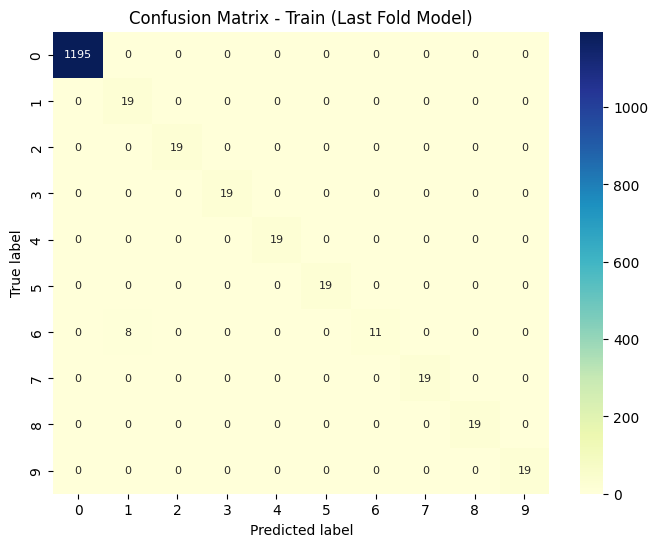

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


2025-06-24 00:45:38.884662: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-24 00:45:38.886196: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

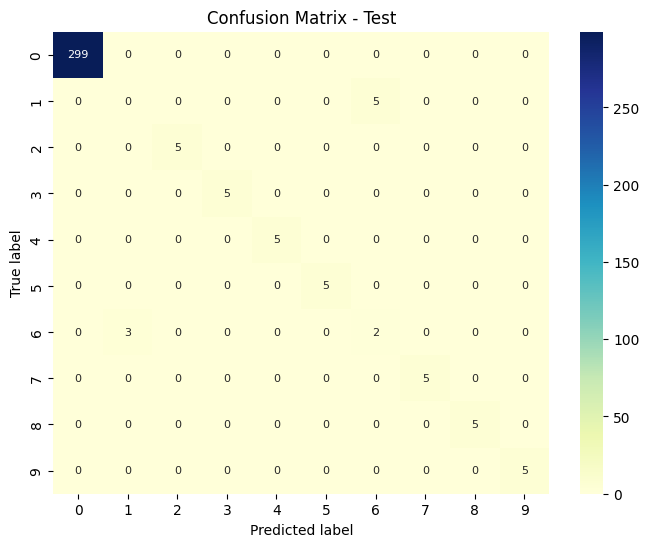

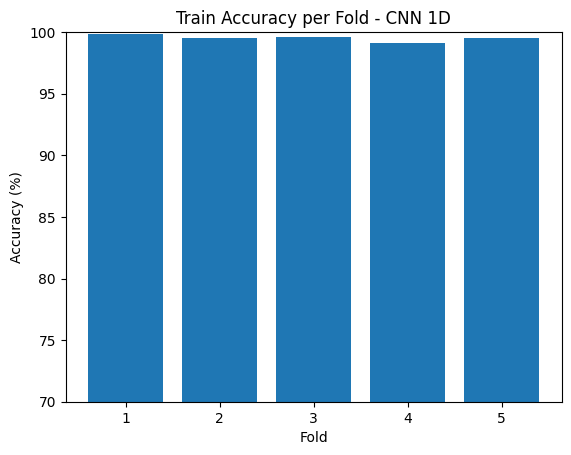

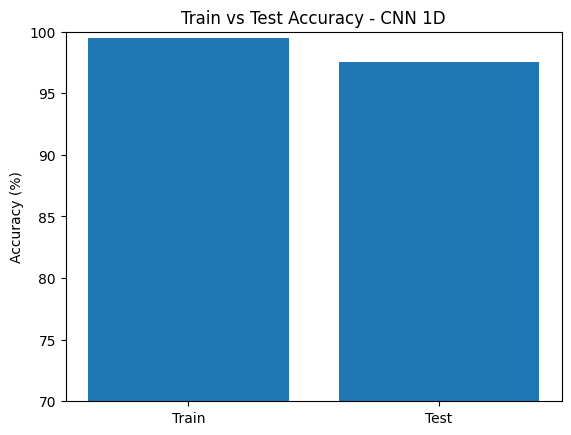

In [9]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
# ------------------ Setup ------------------
foldername = "CNN1D_results/IR_50_1_Ratio/"
os.makedirs(foldername, exist_ok=True)

# Split the data
X_train, y_train, X_test, y_test = time_series_stratified_split(X=X, y=y_positional, train_ratio=0.8)

# Reshape for CNN input
X_1D_train = X_train.reshape([-1, samples_per_block, 1])
X_1D_test = X_test.reshape([-1, samples_per_block, 1])
input_shape = (samples_per_block, 1)

# For K-Fold
y_train_classes = np.argmax(y_train, axis=1)
k_splits = 5
kfold = StratifiedKFold(n_splits=k_splits, shuffle=False)

# Metric storage
accuracy_1D, precision_1D, recall_1D, f1_1D, log_loss_1D, balanced_accuracy_1D = [], [], [], [], [], []
accuracy_1D_test, precision_1D_test, recall_1D_test, f1_1D_test, log_loss_1D_test, balanced_accuracy_1D_test = [], [], [], [], [], []

# ------------------ Training Loop ------------------
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_1D_train, y_train_classes)):
    print(f"\nFold {fold + 1}")
    checkpoint_filepath = os.path.join(foldername, f"best_model_{fold + 1}.h5")

    checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy',
                                 save_best_only=True, mode='max', verbose=1)

    model = CNN_1D()
    model.model.fit(
        X_1D_train[train_idx], y_train[train_idx],
        validation_data=(X_1D_train[val_idx], y_train[val_idx]),
        epochs=50,
        verbose=1,
        callbacks=[checkpoint]
    )

    best_model = load_model(checkpoint_filepath)

    # Train fold subset evaluation
    y_pred_train = np.argmax(best_model.predict(X_1D_train[train_idx]), axis=1)
    y_true_train = np.argmax(y_train[train_idx], axis=1)

    accuracy_1D.append(accuracy_score(y_true_train, y_pred_train))
    precision_1D.append(precision_score(y_true_train, y_pred_train, average='weighted'))
    recall_1D.append(recall_score(y_true_train, y_pred_train, average='weighted'))
    f1_1D.append(f1_score(y_true_train, y_pred_train, average='weighted'))
    log_loss_1D.append(log_loss(y_true_train, best_model.predict(X_1D_train[train_idx])))
    balanced_accuracy_1D.append(balanced_accuracy_score(y_true_train, y_pred_train))

    # Fixed test set evaluation
    y_pred_test = np.argmax(best_model.predict(X_1D_test), axis=1)
    y_true_test = np.argmax(y_test, axis=1)

    accuracy_1D_test.append(accuracy_score(y_true_test, y_pred_test))
    precision_1D_test.append(precision_score(y_true_test, y_pred_test, average='weighted'))
    recall_1D_test.append(recall_score(y_true_test, y_pred_test, average='weighted'))
    f1_1D_test.append(f1_score(y_true_test, y_pred_test, average='weighted'))
    log_loss_1D_test.append(log_loss(y_true_test, best_model.predict(X_1D_test)))
    balanced_accuracy_1D_test.append(balanced_accuracy_score(y_true_test, y_pred_test))

    print(f"Best model saved at: {checkpoint_filepath}")

# ------------------ Metric Summary ------------------

def summarize_metric(name, train_vals, test_vals):
    print(f"{name} (Train): {np.mean(train_vals)*100:.2f}%")
    print(f"{name} (Test):  {np.mean(test_vals)*100:.2f}%")

summarize_metric("Accuracy", accuracy_1D, accuracy_1D_test)
summarize_metric("Precision", precision_1D, precision_1D_test)
summarize_metric("Recall", recall_1D, recall_1D_test)
summarize_metric("F1-score", f1_1D, f1_1D_test)

print(f"Train Log Loss: {np.mean(log_loss_1D):.4f}")
print(f"Test Log Loss:  {np.mean(log_loss_1D_test):.4f}")
print(f"Train Balanced Accuracy: {np.mean(balanced_accuracy_1D)*100:.2f}%")
print(f"Test Balanced Accuracy:  {np.mean(balanced_accuracy_1D_test)*100:.2f}%")

# ------------------ Confusion Matrices ------------------

def plot_confusion_matrix(model, X, y, title):
    y_pred = np.argmax(model.predict(X), axis=1)
    y_true = np.argmax(y, axis=1)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu", annot_kws={"fontsize":8})
    plt.title(title)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

# Confusion matrix from last fold model (optional)
plot_confusion_matrix(best_model, X_1D_train, y_train, "Confusion Matrix - Train (Last Fold Model)")
plot_confusion_matrix(best_model, X_1D_test, y_test, "Confusion Matrix - Test")

# ------------------ Bar Plots ------------------

plt.figure()
plt.title('Train Accuracy per Fold - CNN 1D')
plt.bar(np.arange(1, k_splits + 1), [x * 100 for x in accuracy_1D])
plt.ylabel('Accuracy (%)')
plt.xlabel('Fold')
plt.ylim([70, 100])
plt.show()

plt.figure()
plt.title('Train vs Test Accuracy - CNN 1D')
plt.bar(['Train', 'Test'], [np.mean(accuracy_1D) * 100, np.mean(accuracy_1D_test) * 100])
plt.ylabel('Accuracy (%)')
plt.ylim([70, 100])
plt.show()


In [11]:

# Create DataFrame from per-fold metrics
metrics_df = pd.DataFrame({
    'Fold': np.arange(1, k_splits + 1),
    
    'Train Accuracy (%)': np.array(accuracy_1D) * 100,
    'Test Accuracy (%)': np.array(accuracy_1D_test) * 100,

    'Train Precision (%)': np.array(precision_1D) * 100,
    'Test Precision (%)': np.array(precision_1D_test) * 100,

    'Train Recall (%)': np.array(recall_1D) * 100,
    'Test Recall (%)': np.array(recall_1D_test) * 100,

    'Train F1-score (%)': np.array(f1_1D) * 100,
    'Test F1-score (%)': np.array(f1_1D_test) * 100,

    'Train Log Loss': log_loss_1D,
    'Test Log Loss': log_loss_1D_test,

    'Train Balanced Accuracy (%)': np.array(balanced_accuracy_1D) * 100,
    'Test Balanced Accuracy (%)': np.array(balanced_accuracy_1D_test) * 100,
})

metrics_df

,Fold,Train Accuracy (%),Test Accuracy (%),Train Precision (%),Test Precision (%),Train Recall (%),Test Recall (%),Train F1-score (%),Test F1-score (%),Train Log Loss,Test Log Loss,Train Balanced Accuracy (%),Test Balanced Accuracy (%)
0,1,99.816850,98.837209,99.828297,99.354005,99.816850,98.837209,99.816646,98.615725,0.013606,0.023663,98.666667,92.0
1,2,99.542543,96.511628,99.566477,95.457849,99.542543,96.511628,99.540910,95.825880,0.014302,0.060512,96.708333,76.0
2,3,99.634035,97.965116,99.685499,97.404485,99.634035,97.965116,99.631161,97.456395,0.020925,0.047596,97.333333,86.0
3,4,99.085087,96.802326,99.294245,96.752279,99.085087,96.802326,99.013977,96.308601,0.032835,0.057506,93.333333,78.0
4,5,99.542543,97.674419,99.651462,97.508306,99.542543,97.674419,99.531096,97.577519,0.020720,0.040035,96.875000,84.0


In [12]:
## turn into excel
metrics_df.to_excel(os.path.join(foldername, "Imbalanced_CNN1D_Foldwise_Metrics.xlsx"), index=False)


# Old Code

In [ ]:
# from keras.callbacks import ModelCheckpoint
# from keras.models import load_model

# foldername = "CNN1D_results/IR_50_1_Ratio/"

# # Split the data using your time_series_stratified_split function
# X_train, y_train, X_test, y_test = time_series_stratified_split(X=X, y=y_positional, train_ratio=0.8)

# # Reshape for 1D CNN input
# X_1D_train = X_train.reshape([-1, samples_per_block, 1])
# X_1D_test = X_test.reshape([-1, samples_per_block, 1])

# # Prepare 1D class labels for StratifiedKFold
# y_train_classes = np.argmax(y_train, axis=1)

# # Initialize StratifiedKFold
# from sklearn.model_selection import StratifiedKFold
# k_splits = 5
# kfold = StratifiedKFold(k_splits=k_splits, shuffle=False)

# # Metrics storage
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, balanced_accuracy_score
# accuracy_1D, precision_1D, recall_1D, f1_1D, log_loss_1D, balanced_accuracy_1D = [], [], [], [], [], []
# accuracy_1D_test, precision_1D_test, recall_1D_test, f1_1D_test, log_loss_1D_test, balanced_accuracy_1D_test = [], [], [], [], [], []

# # Training loop with K-Fold
# for fold, (train_idx, val_idx) in enumerate(kfold.split(X_1D_train, y_train_classes)):
#     print(f"\nFold {fold + 1}")
#     checkpoint_filepath = f"CNN1D_results/IR_50_1_Ratio/best_model_{fold + 1}.h5"

#     checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
#     model = CNN_1D()

#     model.model.fit(
#         X_1D_train[train_idx], y_train[train_idx],
#         validation_data=(X_1D_train[val_idx], y_train[val_idx]),
#         epochs=50,
#         verbose=1,
#         callbacks=[checkpoint]
#     )

#     best_model = load_model(checkpoint_filepath)

#     # Train set evaluation
#     y_pred_train = np.argmax(best_model.predict(X_1D_train), axis=1)
#     y_true_train = np.argmax(y_train, axis=1)

#     accuracy_1D.append(accuracy_score(y_true_train, y_pred_train))
#     precision_1D.append(precision_score(y_true_train, y_pred_train, average='weighted'))
#     recall_1D.append(recall_score(y_true_train, y_pred_train, average='weighted'))
#     f1_1D.append(f1_score(y_true_train, y_pred_train, average='weighted'))
#     log_loss_1D.append(log_loss(y_true_train, best_model.predict(X_1D_train)))
#     balanced_accuracy_1D.append(balanced_accuracy_score(y_true_train, y_pred_train))

#     # Test set evaluation
#     y_pred_test = np.argmax(best_model.predict(X_1D_test), axis=1)
#     y_true_test = np.argmax(y_test, axis=1)

#     accuracy_1D_test.append(accuracy_score(y_true_test, y_pred_test))
#     precision_1D_test.append(precision_score(y_true_test, y_pred_test, average='weighted'))
#     recall_1D_test.append(recall_score(y_true_test, y_pred_test, average='weighted'))
#     f1_1D_test.append(f1_score(y_true_test, y_pred_test, average='weighted'))
#     log_loss_1D_test.append(log_loss(y_true_test, best_model.predict(X_1D_test)))
#     balanced_accuracy_1D_test.append(balanced_accuracy_score(y_true_test, y_pred_test))

#     print(f"Best model saved at: {checkpoint_filepath}")



# from keras.callbacks import ModelCheckpoint
# from keras.models import load_model
# from sklearn.model_selection import StratifiedKFold

# # Training with k-fold validation
# from sklearn.metrics import balanced_accuracy_score

# # Training with k-fold validation
# k_splits = 5
# # kfold = KFold(n_splits=kSplits, random_state=42, shuffle=True)
# kfold = StratifiedKFold(n_splits = k_splits, shuffle = False)

# accuracy_1D = []
# precision_1D = []
# recall_1D = []
# f1_1D = []
# log_loss_1D = []
# balanced_accuracy_1D = []  # Store balanced accuracy for each fold
# accuracy_1D_test = []
# precision_1D_test = []
# recall_1D_test = []
# f1_1D_test = []
# log_loss_1D_test = []
# balanced_accuracy_1D_test = []  # Store balanced accuracy for test set

# # early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# # for train_idx, test_idx in kfold.split(X_1D_train, y_train_positional_split):
# for fold, (train_idx, test_idx) in enumerate(kfold.split(X_1D_train, y_train)):

#     # Define where to save the best model
#     checkpoint_filepath = foldername + "best_model_" + str(fold+1) + ".h5"

#     # Classification_1D = CNN_1D()
#     # Classification_1D.model.fit(X_1D_train[train_idx], y_train_positional_split[train_idx],
#     #                             validation_data=(X_1D_train[test_idx], y_train_positional_split[test_idx]),
#     #                             epochs=200, callbacks=[early_stopping], verbose=1)

#     # Create a ModelCheckpoint callback
#     checkpoint = ModelCheckpoint(
#         filepath=checkpoint_filepath,
#         monitor='val_accuracy',  # Monitor validation accuracy
#         save_best_only=True,  # Save only the best model
#         mode='max',  # Maximize accuracy
#         verbose=1
#     ) 

#     Classification_1D = CNN_1D()       
#     history = Classification_1D.model.fit(
#         X_1D_train[train_idx], y_train[train_idx],
#         validation_data=(X_1D_train[test_idx], y_train[test_idx]),  # Validation set for monitoring
#         epochs=50,
#         verbose=1,
#         callbacks=[checkpoint]  # Save the best model
#     )

#     print("Best model saved at:", checkpoint_filepath)
    

In [ ]:
# CNN_1D_best_model = load_model(checkpoint_filepath)
# print("Best model loaded successfully!")

# # Train set metrics
# y_pred_proba_train = CNN_1D_best_model.predict(X_1D_train)
# y_pred_train = np.argmax(y_pred_proba_train, axis=1)
# y_true_train = np.argmax(y_train, axis=1)

# accuracy_1D.append(accuracy_score(y_true_train, y_pred_train))
# precision_1D.append(precision_score(y_true_train, y_pred_train, average='weighted'))
# recall_1D.append(recall_score(y_true_train, y_pred_train, average='weighted'))
# log_loss_1D.append(log_loss(y_true_train, y_pred_proba_train))
# balanced_accuracy_1D.append(balanced_accuracy_score(y_true_train, y_pred_train))  # Balanced accuracy for train set

# # Test set metrics
# y_pred_proba_test = CNN_1D_best_model.predict(X_1D_test)
# y_pred_test = np.argmax(y_pred_proba_test, axis=1)
# y_true_test = np.argmax(y_train, axis=1)

# accuracy_1D_test.append(accuracy_score(y_true_test, y_pred_test))
# precision_1D_test.append(precision_score(y_true_test, y_pred_test, average='weighted'))
# recall_1D_test.append(recall_score(y_true_test, y_pred_test, average='weighted'))
# log_loss_1D_test.append(log_loss(y_true_test, y_pred_proba_test))
# balanced_accuracy_1D_test.append(balanced_accuracy_score(y_true_test, y_pred_test))  # Balanced accuracy for test set


# CNN_1D_best_model = load_model(checkpoint_filepath)
# print("Best model loaded successfully!")

# # Train set metrics (on fold's training subset)
# y_pred_proba_train = CNN_1D_best_model.predict(X_1D_train[train_idx])
# y_pred_train = np.argmax(y_pred_proba_train, axis=1)
# y_true_train = np.argmax(y_train[train_idx], axis=1)

# accuracy_1D.append(accuracy_score(y_true_train, y_pred_train))
# precision_1D.append(precision_score(y_true_train, y_pred_train, average='weighted'))
# recall_1D.append(recall_score(y_true_train, y_pred_train, average='weighted'))
# log_loss_1D.append(log_loss(y_true_train, y_pred_proba_train))
# balanced_accuracy_1D.append(balanced_accuracy_score(y_true_train, y_pred_train))

# # Test set metrics
# y_pred_proba_test = CNN_1D_best_model.predict(X_1D_test)
# y_pred_test = np.argmax(y_pred_proba_test, axis=1)
# y_true_test = np.argmax(y_test, axis=1)  # Fixed

# accuracy_1D_test.append(accuracy_score(y_true_test, y_pred_test))
# precision_1D_test.append(precision_score(y_true_test, y_pred_test, average='weighted'))
# recall_1D_test.append(recall_score(y_true_test, y_pred_test, average='weighted'))
# log_loss_1D_test.append(log_loss(y_true_test, y_pred_proba_test))
# balanced_accuracy_1D_test.append(balanced_accuracy_score(y_true_test, y_pred_test))


In [ ]:
# -----------------------------------------------------------------------------
# Multiclass Classification CNN Model Evaluation with Imbalanced Data
# -----------------------------------------------------------------------------
# # Aggregated metrics
# CNN_1D_train_accuracy = np.mean(accuracy_1D) * 100
# CNN_1D_test_accuracy = np.mean(accuracy_1D_test) * 100
# CNN_1D_train_precision = np.mean(precision_1D) * 100
# CNN_1D_test_precision = np.mean(precision_1D_test) * 100
# CNN_1D_train_recall = np.mean(recall_1D) * 100
# CNN_1D_test_recall = np.mean(recall_1D_test) * 100
# CNN_1D_train_f1 = np.mean(f1_1D) * 100
# CNN_1D_test_f1 = np.mean(f1_1D_test) * 100
# CNN_1D_train_log_loss = np.mean(log_loss_1D)
# CNN_1D_test_log_loss = np.mean(log_loss_1D_test)
# CNN_1D_train_balanced_accuracy = np.mean(balanced_accuracy_1D) * 100  # Average balanced accuracy for train set
# CNN_1D_test_balanced_accuracy = np.mean(balanced_accuracy_1D_test) * 100  # Average balanced accuracy for test set

# # Print metrics
# print(f"Train Accuracy: {CNN_1D_train_accuracy:.2f}%")
# print(f"Test Accuracy: {CNN_1D_test_accuracy:.2f}%")
# print(f"Train Precision: {CNN_1D_train_precision:.2f}%")
# print(f"Test Precision: {CNN_1D_test_precision:.2f}%")
# print(f"Train Recall: {CNN_1D_train_recall:.2f}%")
# print(f"Test Recall: {CNN_1D_test_recall:.2f}%")
# print(f"Train F1-score: {CNN_1D_train_recall:.2f}%")
# print(f"Test F1-score: {CNN_1D_test_recall:.2f}%")
# print(f"Train Log Loss: {CNN_1D_train_log_loss:.4f}")
# print(f"Test Log Loss: {CNN_1D_test_log_loss:.4f}")
# print(f"Train Balanced Accuracy: {CNN_1D_train_balanced_accuracy:.2f}%")
# print(f"Test Balanced Accuracy: {CNN_1D_test_balanced_accuracy:.2f}%")

# # Confusion Matrix Calculation

# def ConfusionMatrix(Model, X, y):
#     y_pred_proba = Model.predict(X)  # Use Model.model instead of Model
#     y_pred = np.argmax(y_pred_proba, axis=1)  # Convert probabilities to class labels
#     y_true = np.argmax(y, axis=1)  # Convert one-hot labels to class indices
#     return confusion_matrix(y_true, y_pred)

# # Plot results - CNN 1D
# plt.figure(1)
# plt.title('Confusion Matrix - CNN 1D Train')
# sns.heatmap(ConfusionMatrix(CNN_1D_best_model, X_1D_train, y_train), annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
# plt.show()

# plt.figure(2)
# plt.title('Confusion Matrix - CNN 1D Test')
# sns.heatmap(ConfusionMatrix(CNN_1D_best_model, X_1D_test, y_test), annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
# plt.show()

# plt.figure(3)
# plt.title('Train - Accuracy - CNN 1D')
# plt.bar(np.arange(1, k_splits + 1), [i * 100 for i in accuracy_1D])
# plt.ylabel('accuracy')
# plt.xlabel('folds')
# plt.ylim([70, 100])
# plt.show()

# plt.figure(4)
# plt.title('Train vs Test Accuracy - CNN 1D')
# plt.bar([1, 2], [CNN_1D_train_accuracy, CNN_1D_test_accuracy])
# plt.ylabel('accuracy')
# plt.xlabel('sets')
# plt.xticks([1, 2], ['Train', 'Test'])
# plt.ylim([70, 100])
# plt.show()